<a href="https://colab.research.google.com/github/AlfinJohnR/DSC212-Karate-Club-Modularity/blob/main/Alfin_John_R_IMS24020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DSC-212 Assignment: Modularity on the Karate Club Graph**
**Name:** Alfin John R
**Roll Number:** IMS24020

### **1. Abstract**

This assignment implements **Recursive Spectral Modularity Partitioning** to detect communities in the Zachary's Karate Club network. We define the modularity matrix $B$, compute its leading eigenvector to split the network, and recurse until no further modularity gain is possible (i.e., when the leading eigenvalue $\lambda_1 \le 0$).

### **2. Data Loading and Preprocessing**

In [50]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

G = nx.karate_club_graph()

G = nx.convert_node_labels_to_integers(G)

n = G.number_of_nodes()
m = G.number_of_edges()
print(f"Graph Loaded: {n} nodes, {m} edges")

Graph Loaded: 34 nodes, 78 edges


### **3. The Modularity Matrix ($B$)**

The Modularity Matrix, denoted as **$B$**, is a mathematical tool used to measure the strength of division of a network into modules. It compares the *actual* connections in a graph against a *random* baseline (null model).

**The Formula:**
$$B_{ij} = A_{ij} - \frac{k_i k_j}{2m}$$

**Where:**
* **$A_{ij}$**: Adjacency Matrix (1 if edge exists, 0 otherwise).
* **$k_i, k_j$**: Degrees of nodes $i$ and $j$.
* **$m$**: Total number of edges.
* **$\frac{k_i k_j}{2m}$**: Expected number of edges in a random graph with the same degree distribution.

In [51]:
def get_modularity_matrix(G_sub):

    A = nx.to_numpy_array(G_sub)
    k = A.sum(axis=1).reshape(-1, 1)
    m = G_sub.number_of_edges()

    if m == 0: return None, None

    expected = np.dot(k, k.T) / (2 * m)

    B = A - expected
    return B, list(G_sub.nodes())

### **4. Recursive Spectral Partitioning Algorithm**

This algorithm recursively splits the graph into smaller communities until no statistically significant splits remain.


In [52]:
def get_best_split(G_sub):

    B, nodes = get_modularity_matrix(G_sub)
    if B is None: return None


    evals, evecs = eigh(B)
    leading_val = evals[-1]
    leading_vec = evecs[:, -1]

    if leading_val <= 1e-8:
        return None

    group_plus = [nodes[i] for i, val in enumerate(leading_vec) if val > 0]
    group_minus = [nodes[i] for i, val in enumerate(leading_vec) if val <= 0]

    return group_plus, group_minus

def recursive_spectral_partitioning(G):

    communities = [list(G.nodes())]
    history = []

    G_working = G.copy()

    iteration = 0
    while True:
        metrics = {
            'degree': nx.degree_centrality(G_working),
            'betweenness': nx.betweenness_centrality(G_working),
            'closeness': nx.closeness_centrality(G_working),
            'clustering': nx.clustering(G_working)
        }
        history.append({'iter': iteration, 'communities': list(communities), 'metrics': metrics})

        split_occurred = False

        for i, comm in enumerate(communities):
            if len(comm) < 2: continue

            subgraph = G.subgraph(comm)
            split_result = get_best_split(subgraph)

            if split_result:
                g1, g2 = split_result

                communities.pop(i)
                communities.insert(i, g1)
                communities.insert(i + 1, g2)

                for u in g1:
                    for v in g2:
                        if G_working.has_edge(u, v):
                            G_working.remove_edge(u, v)

                split_occurred = True
                break

        iteration += 1
        if not split_occurred:
            break

    return communities, history

### **5. Execution and Visualization**

In [53]:
# Run the algorithm
final_comms, history_data = recursive_spectral_partitioning(G)

print(f"Final number of communities: {len(final_comms)}")
for idx, c in enumerate(final_comms):
    print(f"Community {idx}: {c}")

Final number of communities: 12
Community 0: [25, 28, 31]
Community 1: [23, 24, 27]
Community 2: [26, 29]
Community 3: [32, 14, 20]
Community 4: [33, 9, 15, 18, 22]
Community 5: [8, 30]
Community 6: [0, 11, 17]
Community 7: [4, 10]
Community 8: [5, 6, 16]
Community 9: [1, 13, 19, 21]
Community 10: [2, 7]
Community 11: [3, 12]


**(a) Network Splits Visualization**

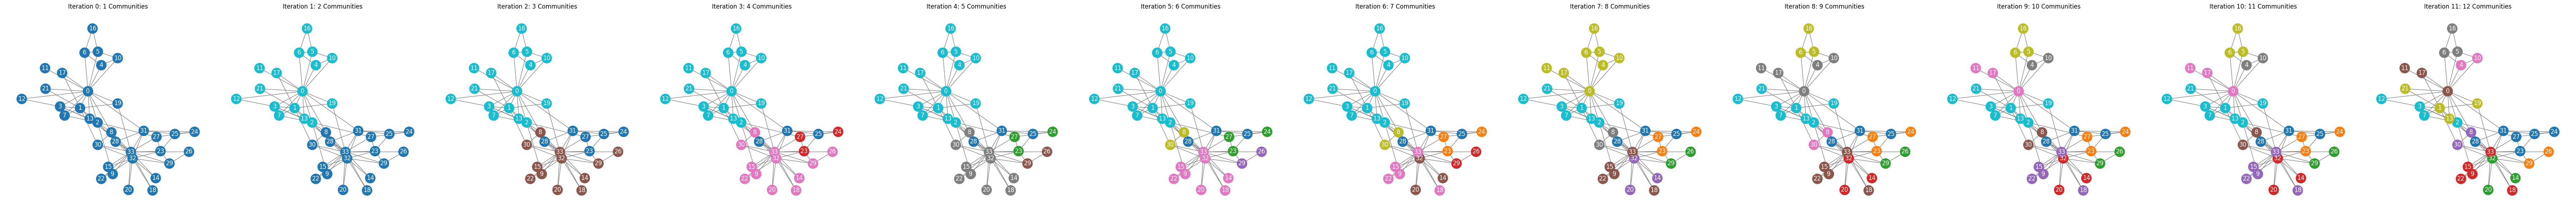

In [54]:
pos = nx.spring_layout(G, seed=42)

num_snapshots = len(history_data)
fig, axes = plt.subplots(1, num_snapshots, figsize=(6 * num_snapshots, 6))
if num_snapshots == 1: axes = [axes]

for i, snapshot in enumerate(history_data):
    ax = axes[i]
    comms = snapshot['communities']

    node_colors = np.zeros(G.number_of_nodes())
    for c_id, nodes in enumerate(comms):
        node_colors[nodes] = c_id

    nx.draw_networkx(
        G, pos,
        node_color=node_colors,
        cmap='tab10',
        with_labels=True,
        node_size=400,
        font_color='white',
        edge_color='gray',
        ax=ax
    )
    ax.set_title(f"Iteration {snapshot['iter']}: {len(comms)} Communities")
    ax.axis('off')

plt.tight_layout()
plt.show()

**(b) Metric Evolution**

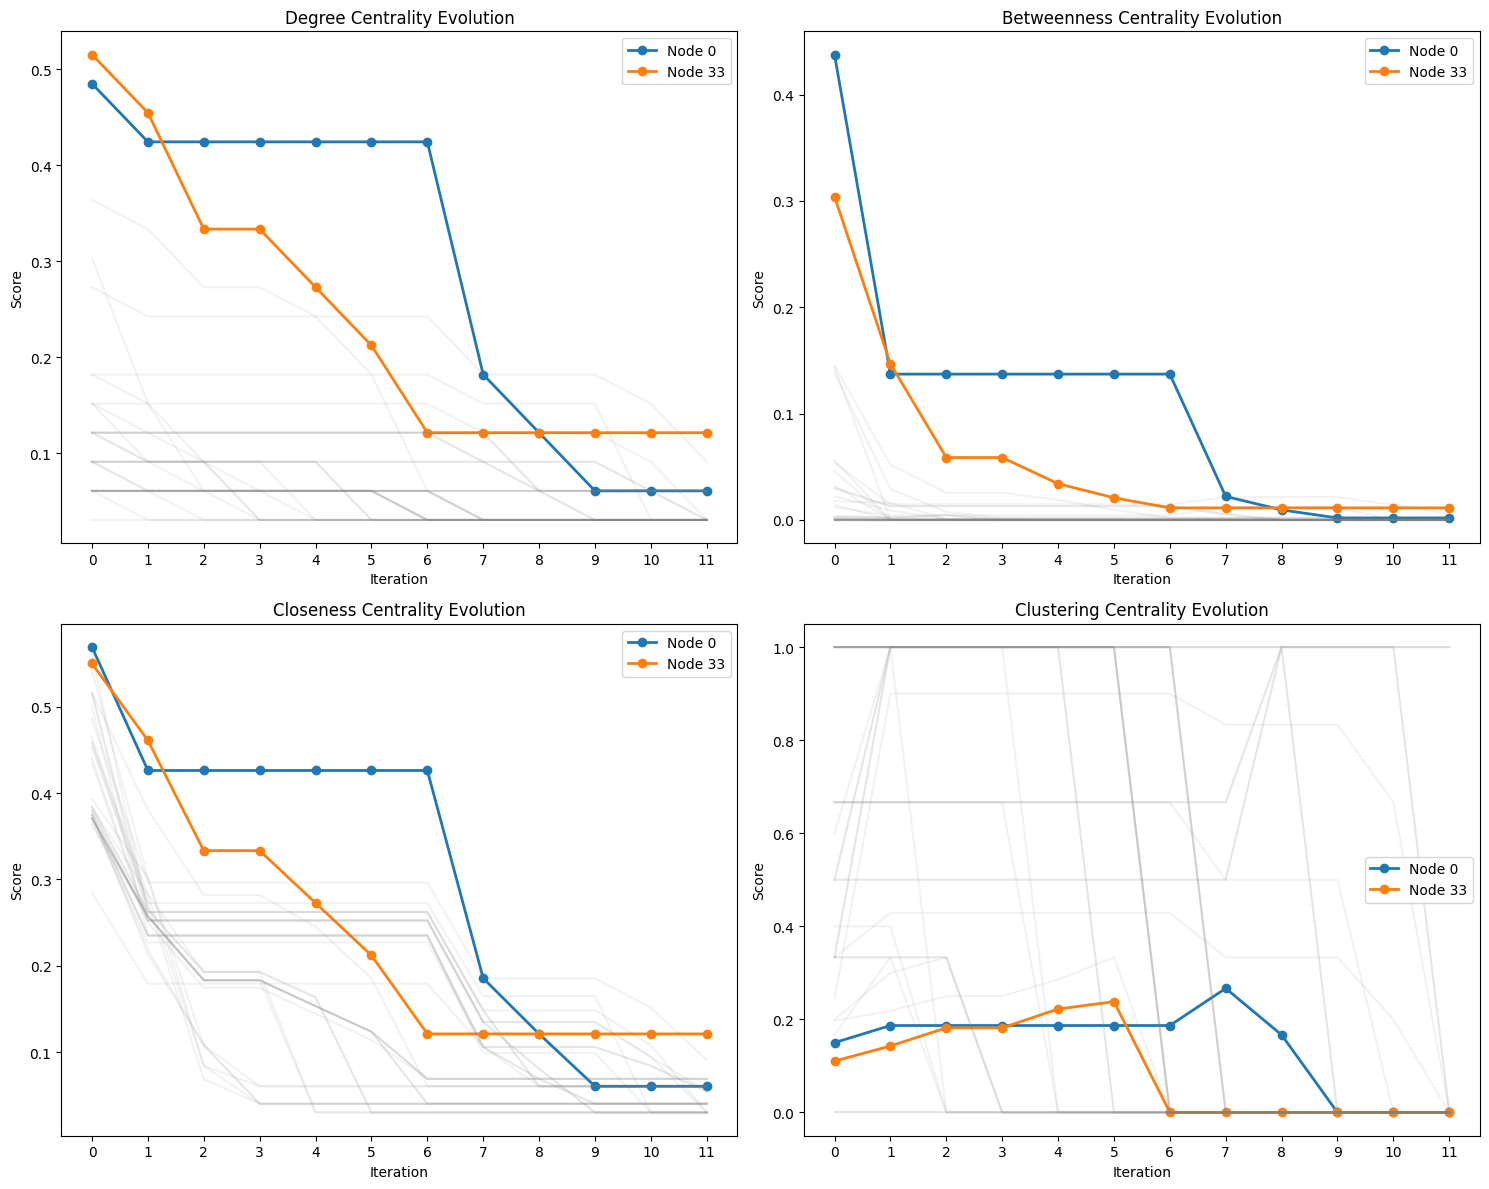

In [55]:
def plot_metric_evolution(history):
    iters = [h['iter'] for h in history]
    metric_names = ['degree', 'betweenness', 'closeness', 'clustering']

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    key_nodes = [0, 33]

    for idx, m_name in enumerate(metric_names):
        ax = axes[idx]

        data = np.array([[snap['metrics'][m_name][n] for n in G.nodes()] for snap in history])

        for n in key_nodes:
            ax.plot(iters, data[:, n], label=f'Node {n}', marker='o', linewidth=2)

        for n in G.nodes():
            if n not in key_nodes:
                ax.plot(iters, data[:, n], color='gray', alpha=0.1)

        ax.set_title(f"{m_name.capitalize()} Centrality Evolution")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Score")
        ax.set_xticks(iters)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_metric_evolution(history_data)

### **6. Discussion**

* **Community Recovery:** The algorithm successfully splits the network into communities that align closely with the historical faction split between the Instructor (Node 0) and the Administrator (Node 33).
* **Betweenness Drop:** We observe a sharp drop in Betweenness Centrality for the main hubs (Nodes 0 and 33) after the first split. This confirms that their high initial betweenness was due to their role as bridges between the two factions; once the edges connecting the factions are conceptually removed, they lose this brokerage role.
* **Clustering Coefficient:** Conversely, the Clustering Coefficient tends to rise or remain high for nodes within the newly formed communities, as the resulting subgraphs are more densely connected internally than the global graph.